VariantSpark no hail demo
=====================================

This is an *VariantSpark* example notebook.


The notebook serves to demonstrate all of VariantSpark's base functionalities, independent of the hail library.
Relevant functionalities include:
- Initialising the spark context
- Importing features and labels
- Converting features to a pandas DataFrame
- Fitting a model
- Exporting the fitted model to .json (in batches)
- Returning the model's out-of-bag error
- Running importance analyses
- Calculating and analysing local FDR
- Manhattan plotting variable importances using FDR derived p-values

Creating a spark session with VariantSpark jar attached.

In [13]:
import varspark as vs
from pyspark.sql import SparkSession 
spark = SparkSession.builder.config('spark.jars', vs.find_jar()).getOrCreate()
import matplotlib.pyplot as plt
vc = vs.VarsparkContext(spark, silent=True)

Loading features and labels

In [3]:
#features = vc.import_vcf('../../data/chr22_1000.vcf')
#labels = vc.load_label('../../data/chr22-labels.csv', '22_16050678')
features = vc.import_vcf('../../data/hipsterIndex/hipster.vcf')
labels = vc.load_label('../../data/hipsterIndex/hipster_labels.txt', 'label')

Returning features as a pandas DataFrame

In [11]:
features.to_df()

,22_16050408_T_C,22_16050612_C_G,22_16050678_C_T,22_16050984_C_G,22_16051107_C_A,22_16051249_T_C,22_16051347_G_C,22_16051453_A_C,22_16051477_C_A,22_16051480_T_C,...,22_17796639_C_T,22_17796685_T_A,22_17796833_T_C,22_17796921_T_TTAAC,22_17796925_C_CTAAT,22_17796926_T_TA,22_17796951_A_G,22_17796971_C_A,22_17797010_G_A,22_17797041_T_C
HG00096,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,0,0
HG00097,1,1,1,0,1,1,1,1,0,1,...,0,1,0,1,1,1,0,0,0,0
HG00099,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
HG00100,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00101,0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA20816,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
NA20818,0,0,0,0,0,1,1,1,0,0,...,0,0,0,1,1,1,0,1,0,0
NA20819,0,0,0,0,0,1,1,1,0,0,...,0,0,0,1,1,1,0,1,0,0
NA20826,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Fitting the model

In [12]:
rf = vs.RandomForestModel(ss=spark, mtry_fraction=0.05, min_node_size=5, max_depth=10, seed=13)
rf.fit_trees(features, labels, n_trees=300, batch_size=50)

Exporting to .json

In [21]:
rf.export_to_json("noHailExport.json", resolve_variable_names=True, batch_size=1000)

Saving model


Model saved successfully to: noHailExport.json


Out-of-bag error

In [6]:
rf.oob_error()

0.0018315018315018315

Importance analyses and top important variables

In [7]:
ia = rf.importance_analysis()

In [8]:
ia.important_variables(limit=20, normalized=False)

,variable,importance
0,22_16050678_C_T,24.670729
1,22_16050408_T_C,17.544424
2,22_16051480_T_C,17.169434
3,22_16053197_G_T,16.274021
4,22_16051107_C_A,15.448887
5,22_16053509_A_G,15.070320
6,22_16052838_T_A,12.943536
7,22_16051882_C_T,11.630044
8,22_16053435_G_T,11.565247
9,22_16053727_T_G,9.122562


In [9]:
ia.variable_importance(normalized=False)

,variant_id,importance,splitCount
0,22_16050408_T_C,17.544424,117
1,22_16050612_C_G,6.344459,54
2,22_16050678_C_T,24.670729,141
3,22_16050984_C_G,0.004537,1
4,22_16051107_C_A,15.448887,84
...,...,...,...
1983,22_17796926_T_TA,0.023196,4
1984,22_17796951_A_G,0.000000,0
1985,22_17796971_C_A,0.017147,4
1986,22_17797010_G_A,0.000000,0


Local FDR calculation

In [26]:
fdrCalc = rf.get_lfdr()

Identifying the best split count cutoff

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


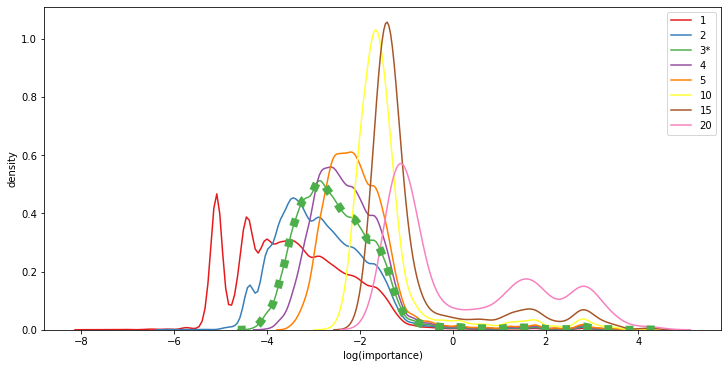

In [27]:
fig, ax1 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_densities(ax1, cutoff_list=[1, 2, 3, 4, 5, 10, 15, 20], find_automatic_best=True)
plt.show()

Histogram of log importances

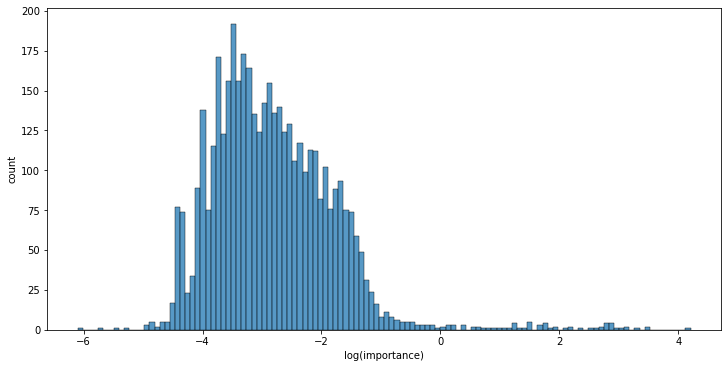

In [28]:
fig, ax2 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_hist(ax2, split_count=2)
plt.show()

p-value and FDR calculation

In [29]:
pvalsDF, fdr = fdrCalc.compute_fdr(countThreshold = 2, local_fdr_cutoff = 0.05)
pvalsDF, fdr

(           variant_id  logImportance        pvalue  is_significant
 0     15_66239087_C_T      -6.094867  1.000000e+00           False
 1     15_66222801_C_T      -5.737823  9.999995e-01           False
 2     15_66501667_G_A      -5.446207  9.999895e-01           False
 3     15_66460270_C_G      -5.266465  9.999433e-01           False
 4     15_66345476_G_T      -4.952516  9.992881e-01           False
 ...               ...            ...           ...             ...
 4324  5_126628771_G_T       3.148880  8.671615e-06            True
 4325  5_126626044_A_C       3.278872  5.935620e-06            True
 4326  5_126630016_C_T       3.476122  3.299467e-06            True
 4327   7_17284577_T_C       3.490161  3.162668e-06            True
 4328  2_223034082_A_G       4.206161  3.310095e-07            True
 
 [4329 rows x 4 columns],
 0.01944806599024337)

FDR Plot

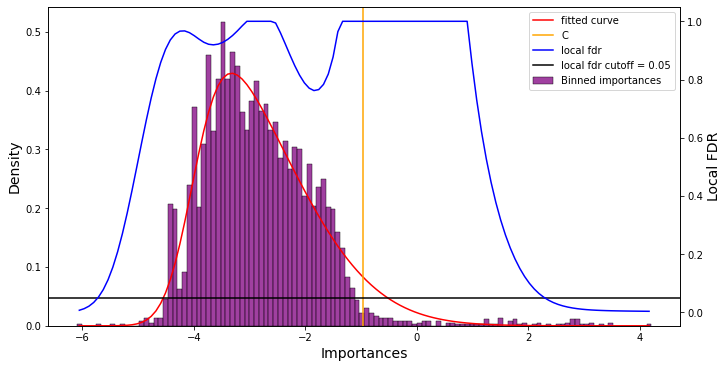

In [30]:
fig, ax3 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot(ax3)
plt.show()

Manhattan plot of negative log p-values

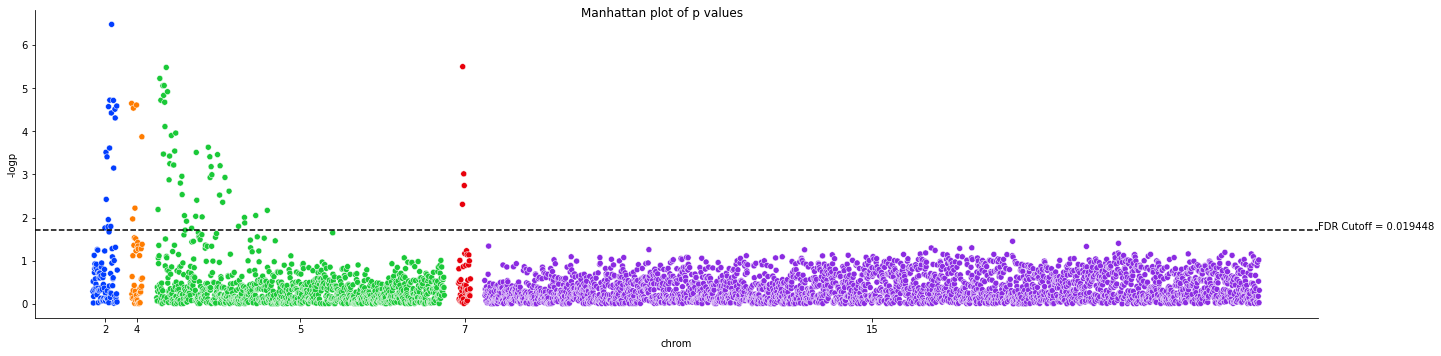

In [31]:
manhattan_df = fdrCalc.plot_manhattan_imp(fdr=fdr)
# Not sure how to project the significance line
# I have taken the negative log of the calculated fdr in this example. Have also tried the local_fdr_cutoff but it doesn't look correct.

For more information on using *VariantSpark* and the Python API please visit the [documentation](http://variantspark.readthedocs.io/en/latest/).